In [13]:
import pandas as pd
import numpy as np
import cv2
from glob import glob
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights,\
                                            DeepLabV3_MobileNet_V3_Large_Weights, deeplabv3_mobilenet_v3_large,\
                                            fcn_resnet101, FCN_ResNet101_Weights
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import v2, InterpolationMode

from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

In [14]:
inputs_path = "./inputs"
outputs_path = "./outputs"

In [15]:
df = pd.read_csv("metadata.csv")
df_train, df_val = train_test_split(df, test_size=0.3, random_state=101)
df_train.to_csv("meta_train.csv"), df_val.to_csv("meta_val.csv")

cv_splits = []

df_train = shuffle(df_train)
cv_splits.extend(np.array_split(df_train, 4))
cv_splits

[                 src_id                                styled_id  \
 12153  ISIC_0015390.jpg  styled_inputs/3_styled_ISIC_0015390.jpg   
 11200  ISIC_0014927.jpg  styled_inputs/0_styled_ISIC_0014927.jpg   
 2101   ISIC_0000515.jpg  styled_inputs/1_styled_ISIC_0000515.jpg   
 7769   ISIC_0013181.jpg  styled_inputs/4_styled_ISIC_0013181.jpg   
 1209   ISIC_0000269.jpg  styled_inputs/4_styled_ISIC_0000269.jpg   
 ...                 ...                                      ...   
 9653   ISIC_0014169.jpg  styled_inputs/3_styled_ISIC_0014169.jpg   
 8583   ISIC_0013585.jpg  styled_inputs/3_styled_ISIC_0013585.jpg   
 10895  ISIC_0014814.jpg  styled_inputs/0_styled_ISIC_0014814.jpg   
 12327  ISIC_0015593.jpg  styled_inputs/2_styled_ISIC_0015593.jpg   
 3017   ISIC_0008207.jpg  styled_inputs/2_styled_ISIC_0008207.jpg   
 
                              mask_id  
 12153  ISIC_0015390_segmentation.png  
 11200  ISIC_0014927_segmentation.png  
 2101   ISIC_0000515_segmentation.png  
 7769   IS

In [16]:
pairwise_ = v2.Compose([
    v2.RandomApply([
        v2.RandomAffine(69),
        v2.RandomVerticalFlip()
    ])
])

def pairwise_transform(x_image, y_image):
#     print(x_image.shape, y_image.shape)
    composed = torch.cat([x_image, y_image], dim=0)
    rotated = pairwise_(composed)
    x, y = rotated[:3, :, :], rotated[3:, :, :]
    return x, y

train_transform = []
val_transform = []

In [17]:
class GeneratedImageDataset(Dataset):
    def __init__(self, metadata, train_path, labels_path, transform=None, target_transform=None):
        if isinstance(metadata, str):
            self.metadata = pd.read_csv(metadata)
        elif isinstance(metadata, pd.DataFrame):
            self.metadata = metadata
        else:
            raise NotImplementedError
        
#         self.input_path = train_path
        self.gt_path = labels_path
        
        self.transform = transform
        self.target_transform = target_transform
            
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        row = self.metadata.iloc[idx, 1:]
        x, y = row
        
        x = Image.open(x).convert("RGB")
        y = Image.open(self.gt_path + "/" + y)
        
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        
        x, y = pairwise_transform(x, y)
        
        y = y / 255.0
        
        return x, y

In [18]:
size = 224
interpolation = InterpolationMode.BILINEAR

transforms_ =  v2.Compose([
    v2.ToTensor(),
    v2.RandomApply([
        v2.ColorJitter(hue=0.1, brightness=0.4),
        v2.RandomChoice([
            v2.RandomAdjustSharpness(2),
            v2.GaussianBlur(kernel_size=3, sigma=(0.01, 0.1))
        ]),
        v2.RandomErasing(p=0.1, scale=(0.01, 0.2))
    ])
])

target_transforms_ = v2.Compose([
    v2.ToTensor(),
    v2.Resize((size, size))
])

ds = GeneratedImageDataset(cv_splits[0], inputs_path, outputs_path, transform=transforms_, target_transform=target_transforms_) 

C:\Users\nesemenpolkov\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [19]:
pair = ds[5]
pair[1].max()

C:\Users\nesemenpolkov\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.)

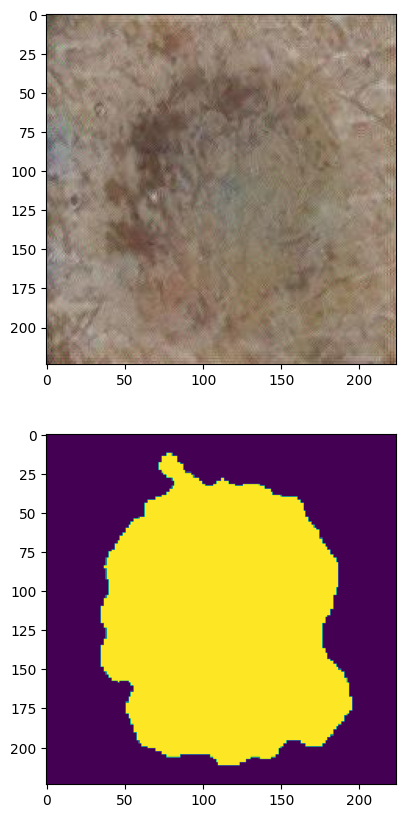

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(pair[0].permute(1,2,0))
plt.subplot(2,1,2)
plt.imshow(pair[1].squeeze(0))

In [21]:
# metrics
def iou(pred, target):
    intersection = (pred.eq(target.long())
                    .type_as(pred)
                    .mul(target)
                    .sum()
                   )
    union = pred.sum() + target.sum() - intersection
    return intersection.float() / union

def dice_score(pred, target, smooth=1):  
    smooth = smooth
    intersection = torch.sum(pred.flatten() * target.flatten(), dim=0)
    return (2. * intersection + smooth) / (torch.sum(pred + target) + smooth)

def accuracy_metrics(preds, targets):
    true_positives = (preds * targets).sum()
    false_positives = ((preds - targets) ** 2).sum()
    precision = true_positives / (true_positives + false_positives)

    sum_positives = preds.sum() + targets.sum() 
    recall = true_positives / sum_positives

    return precision, recall

In [22]:
def train(model, loader, optimizer, criterion):
    model.train()
    
    total_loss = 0
    total_dice = 0
    
    for i, batch in enumerate(loader):
        inputs, masks = batch
        inputs = inputs.float().to(device)
        masks = masks.float().to(device)
        
        
        outputs = model(inputs)["out"]
        
#         outputs = torch.nn.functional.softmax(outputs)
        
        flat_out = outputs
        flat_masks = masks
        
        loss = criterion(flat_out, flat_masks)
        
        total_dice += dice_score(torch.nn.functional.sigmoid(flat_out).round(), flat_masks).item()
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        if (i + 1) % 100 == 0:
            print("-" * 90)
            print("| loss:", (total_loss / (i + 1)), "| dice:", (total_dice / (i + 1)), "| iter: [" + str((i + 1)) + "/" \
                  + str(len(loader)) + "]|")
    return total_loss / len(loader), total_dice / len(loader)

In [23]:
def evaluate(model, loader, criterion):
    model.eval()
    
    total_loss = 0
    total_IoU = 0
    total_dice = 0
    total_precision = 0
    total_recall = 0
    
    with torch.no_grad():
        for i, batch in enumerate(loader):
            inputs, masks = batch
            inputs = inputs.float().to(device)
            masks = masks.float().to(device)


            outputs = model(inputs)["out"]

    #         outputs = torch.nn.functional.softmax(outputs)

            flat_out = outputs
            flat_masks = masks

            loss = criterion(flat_out, flat_masks)

            total_dice += dice_score(torch.nn.functional.sigmoid(flat_out).round(), flat_masks).item()
            total_IoU += iou(torch.nn.functional.sigmoid(flat_out).round(), flat_masks).item()
            precision, recall = accuracy_metrics(torch.nn.functional.sigmoid(flat_out).round(), flat_masks)
            total_precision += precision.item()
            total_recall += recall.item()
            total_loss += loss.item()


            if (i + 1) % 100 == 0:
                print("-" * 90)
                print("| loss:", (total_loss / (i + 1)), "| dice:", (total_dice / (i + 1)), "| iter: [" + str((i + 1)) + "/" \
                      + str(len(loader)) + "]|")
                print("| IoU:", (total_IoU / (i + 1)), "| recall:", (total_recall / (i + 1)), "| iter: [" + str((i + 1)) + "/" \
                      + str(len(loader)) + "]|")
                print("| precision:", (total_precision / (i + 1)), "| iter: [" + str((i + 1)) + "/" \
                      + str(len(loader)) + "]|")
    return total_loss / len(loader), total_dice / len(loader), total_IoU / len(loader), total_precision / len(loader), total_recall / len(loader)

In [24]:
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [102]:
EPOCHS = 20

criterion = BCEDiceLoss(eps=1.0, activation="sigmoid").to(device)

splits_loss = []
splits_dice = []
splits_IoU = []
splits_precision = []
splits_recall = []

for i, split in enumerate(cv_splits, start=1):
    print(f"----------------------------------------------Split={i}----------------------------------------------")
    
    weights = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_mobilenet_v3_large(weights=weights)
    model.classifier.append(nn.Conv2d(21, 1, 1, 1))
    model = model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
    
    x_train, x_test = train_test_split(split, test_size=0.2, random_state=101)
    ds_train = GeneratedImageDataset(x_train, 
                                     inputs_path,
                                     outputs_path,
                                     transform=transforms_,
                                     target_transform=target_transforms_
                                    )
    ds_test = GeneratedImageDataset(x_test,
                                    inputs_path,
                                    outputs_path,
                                    transform=transforms_,
                                    target_transform=target_transforms_
                                   )
    train_loader = DataLoader(ds_train, batch_size=16, shuffle=True)
    test_loader = DataLoader(ds_train, batch_size=16, shuffle=False)
    
    train_losses = []
    train_dices = []
    
    val_losses = []
    val_dices = []
    val_IoU = []
    val_precision = []
    val_recall = []
    
    best_epoch_loss = np.inf
    
    for epoch in range(1, EPOCHS + 1):
        print(f"================================Started epoch №{epoch}================================")
        train_loss, train_dice = train(model, train_loader, optimizer, criterion)
        print("Train loss:", train_loss, "| train dice:", train_dice)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        epoch_loss, epoch_dice, epoch_IoU, epoch_precision, epoch_recall = evaluate(model, test_loader, criterion)
        print("Eval loss:", epoch_loss, "| eval dice:", epoch_dice,
              " | eval IoU:", epoch_IoU, " | eval precision:", epoch_precision, " | eval recall:", epoch_recall)
        val_losses.append(epoch_loss)
        val_dices.append(epoch_dice)
        val_IoU.append(epoch_IoU)
        val_precision.append(epoch_precision)
        val_recall.append(epoch_recall)
        if epoch_loss < best_epoch_loss:
            best_epoch_loss = epoch_loss
            torch.save(model.state_dict(), f"mobilenet_v3_large_deeplabv3_split_{i}_bcediceloss-v2.pt")
            print("**********************************BEST VAL LOSS SCORE**********************************")
            print(f"BEST LOSS: {epoch_loss}, BEST DICE: {epoch_dice}, BEST IoU: {epoch_IoU}")
            print("***************************************************************************************")
        scheduler.step(epoch_loss)
    splits_loss.append(val_losses)
    splits_dice.append(val_dices)
    splits_IoU.append(val_IoU)
    splits_precision.append(val_precision)
    splits_recall.append(val_recall)

----------------------------------------------Split=1----------------------------------------------
================================Started epoch №1================================
------------------------------------------------------------------------------------------
| loss: 0.8241298198699951 | dice: 0.609526927205934 | iter: [100/114]|
Train loss: 0.8052938031522852 | train dice: 0.62034775581016
------------------------------------------------------------------------------------------
| loss: 0.6458804592490196 | dice: 0.7090510576963425 | iter: [100/114]|
| IoU: 0.5527546423673629 | recall: 0.354525081217289 | iter: [100/114]|
| precision: 0.553016591668129 | iter: [100/114]|
Eval loss: 0.6522994410050543 | eval dice: 0.7041818321796885  | eval IoU: 0.5472322992588344  | eval precision: 0.547498225120076  | eval recall: 0.35209045258530397
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.6522994410050543, BEST DICE: 0.70418183

------------------------------------------------------------------------------------------
| loss: 0.39178115159273147 | dice: 0.8286382406949997 | iter: [100/114]|
Train loss: 0.390648719511534 | train dice: 0.8291242598441609
------------------------------------------------------------------------------------------
| loss: 0.34400337338447573 | dice: 0.8483053958415985 | iter: [100/114]|
| IoU: 0.739594389796257 | recall: 0.42415245711803434 | iter: [100/114]|
| precision: 0.7395846962928772 | iter: [100/114]|
Eval loss: 0.34651830452576016 | eval dice: 0.8467892016235151  | eval IoU: 0.7375539729469701  | eval precision: 0.7375613864053759  | eval recall: 0.4233943508905277
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.34651830452576016, BEST DICE: 0.8467892016235151, BEST IoU: 0.7375539729469701
***************************************************************************************
================================Started epoch 

------------------------------------------------------------------------------------------
| loss: 0.34007435813546183 | dice: 0.8490110665559769 | iter: [100/114]|
Train loss: 0.33608398403514894 | train dice: 0.8505838654543224
------------------------------------------------------------------------------------------
| loss: 0.29079063817858697 | dice: 0.8721028929948806 | iter: [100/114]|
| IoU: 0.7757584375143051 | recall: 0.4360512375831604 | iter: [100/114]|
| precision: 0.7759060764312744 | iter: [100/114]|
Eval loss: 0.28869986285765964 | eval dice: 0.8729145500743598  | eval IoU: 0.7769358210396349  | eval precision: 0.7771369176998473  | eval recall: 0.4364570648523799
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.28869986285765964, BEST DICE: 0.8729145500743598, BEST IoU: 0.7769358210396349
***************************************************************************************
================================Started epoc

Train loss: 0.4650027796364667 | train dice: 0.7938423057397207
------------------------------------------------------------------------------------------
| loss: 0.4128903415799141 | dice: 0.8176387411355972 | iter: [100/114]|
| IoU: 0.6952210551500321 | recall: 0.4088190746307373 | iter: [100/114]|
| precision: 0.6951242911815644 | iter: [100/114]|
Eval loss: 0.41354124783946755 | eval dice: 0.8171510806209162  | eval IoU: 0.694626884502277  | eval precision: 0.6945060956896397  | eval recall: 0.40857524333292977
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.41354124783946755, BEST DICE: 0.8171510806209162, BEST IoU: 0.694626884502277
***************************************************************************************
================================Started epoch №7================================
------------------------------------------------------------------------------------------
| loss: 0.4604636415839195 | dice: 0.794

Eval loss: 0.33331017313819183 | eval dice: 0.852971307018347  | eval IoU: 0.7464692712875834  | eval precision: 0.7470150067095171  | eval recall: 0.42648542110334364
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.33331017313819183, BEST DICE: 0.852971307018347, BEST IoU: 0.7464692712875834
***************************************************************************************
================================Started epoch №15================================
------------------------------------------------------------------------------------------
| loss: 0.37052647545933726 | dice: 0.8367445570230484 | iter: [100/114]|
Train loss: 0.3647129305622034 | train dice: 0.8390170022060996
------------------------------------------------------------------------------------------
| loss: 0.3267280140519142 | dice: 0.8538100790977478 | iter: [100/114]|
| IoU: 0.7478971850872039 | recall: 0.426904798746109 | iter: [100/114]|
| precision: 0.74

------------------------------------------------------------------------------------------
| loss: 0.5923838353157044 | dice: 0.7378242444992066 | iter: [100/114]|
Train loss: 0.5914402964868044 | train dice: 0.7376177744907245
------------------------------------------------------------------------------------------
| loss: 0.5191805210709571 | dice: 0.7765867960453033 | iter: [100/114]|
| IoU: 0.6368823072314262 | recall: 0.38829305917024615 | iter: [100/114]|
| precision: 0.6380808800458908 | iter: [100/114]|
Eval loss: 0.5213197425269244 | eval dice: 0.7751456974891194  | eval IoU: 0.6351455355945387  | eval precision: 0.636355724512485  | eval recall: 0.3875725013122224
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.5213197425269244, BEST DICE: 0.7751456974891194, BEST IoU: 0.6351455355945387
***************************************************************************************
================================Started epoch №4=

------------------------------------------------------------------------------------------
| loss: 0.39086473882198336 | dice: 0.8308847677707673 | iter: [100/114]|
Train loss: 0.3900455576285981 | train dice: 0.831060627050567
------------------------------------------------------------------------------------------
| loss: 0.34977453634142874 | dice: 0.8450228518247604 | iter: [100/114]|
| IoU: 0.732964591383934 | recall: 0.4225111722946167 | iter: [100/114]|
| precision: 0.7342695486545563 | iter: [100/114]|
Eval loss: 0.34917346126677695 | eval dice: 0.8463315582066252  | eval IoU: 0.7348287753891527  | eval precision: 0.7360929120005223  | eval recall: 0.42316552892065884
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.34917346126677695, BEST DICE: 0.8463315582066252, BEST IoU: 0.7348287753891527
***************************************************************************************
================================Started epoch 

------------------------------------------------------------------------------------------
| loss: 0.3388872456550598 | dice: 0.851793521642685 | iter: [100/114]|
Train loss: 0.34425364826854904 | train dice: 0.8506956084778434
------------------------------------------------------------------------------------------
| loss: 0.29945781618356704 | dice: 0.8669914889335633 | iter: [100/114]|
| IoU: 0.7669398671388626 | recall: 0.43349552661180496 | iter: [100/114]|
| precision: 0.7682420182228088 | iter: [100/114]|
Eval loss: 0.300295841144888 | eval dice: 0.8672707771000109  | eval IoU: 0.7673583825429281  | eval precision: 0.7686320538060707  | eval recall: 0.4336351720910323
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.300295841144888, BEST DICE: 0.8672707771000109, BEST IoU: 0.7673583825429281
***************************************************************************************
----------------------------------------------Spl

------------------------------------------------------------------------------------------
| loss: 0.42328389912843706 | dice: 0.8141302573680878 | iter: [100/114]|
Train loss: 0.42222832640012103 | train dice: 0.8134924434778983
------------------------------------------------------------------------------------------
| loss: 0.3588514091074467 | dice: 0.842913253903389 | iter: [100/114]|
| IoU: 0.7302662819623947 | recall: 0.4214563724398613 | iter: [100/114]|
| precision: 0.7314627087116241 | iter: [100/114]|
Eval loss: 0.3624776874979337 | eval dice: 0.8408602408149786  | eval IoU: 0.7271421980439571  | eval precision: 0.728305892463316  | eval recall: 0.4204298592450326
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.3624776874979337, BEST DICE: 0.8408602408149786, BEST IoU: 0.7271421980439571
***************************************************************************************
================================Started epoch №9=

------------------------------------------------------------------------------------------
| loss: 0.33627981185913086 | dice: 0.8511305105686188 | iter: [100/114]|
Train loss: 0.3368271032446309 | train dice: 0.8508966680158648
------------------------------------------------------------------------------------------
| loss: 0.3102639466524124 | dice: 0.8611640876531601 | iter: [100/114]|
| IoU: 0.7588215243816375 | recall: 0.4305818143486977 | iter: [100/114]|
| precision: 0.7590653592348099 | iter: [100/114]|
Eval loss: 0.3124870078866942 | eval dice: 0.8604073221223396  | eval IoU: 0.7579578963810938  | eval precision: 0.758229449391365  | eval recall: 0.4302034229040146
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.3124870078866942, BEST DICE: 0.8604073221223396, BEST IoU: 0.7579578963810938
***************************************************************************************
================================Started epoch №17

In [19]:
ds_val = GeneratedImageDataset(df_val,
                                    inputs_path,
                                    outputs_path,
                                    transform=transforms_,
                                    target_transform=target_transforms_
                                   )
val_loader = DataLoader(ds_val, batch_size=16, shuffle=True)

In [28]:
for i in range(1, 5):
    weights = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
    model = deeplabv3_mobilenet_v3_large(weights=weights)
    model.classifier.append(nn.Conv2d(21, 1, 1, 1))
    model.load_state_dict(torch.load(f"mobilenet_v3_large_deeplabv3_split_{i}_bcediceloss-v2.pt"))
    model = model.to(device)
    loss_, dice_, iou_, precision_, recall_ = evaluate(model, val_loader, criterion)
    print(f"=====================MODEL {i}=====================")
    print("Loss:", loss_, "dice:", dice_, "iou:", iou_, "precision:", precision_, "recall:", recall_)

------------------------------------------------------------------------------------------
| loss: 0.48023164480924607 | dice: 0.7880759543180466 | iter: [100/244]|
| IoU: 0.65340177744627 | recall: 0.3940376442670822 | iter: [100/244]|
| precision: 0.65340177744627 | iter: [100/244]|
------------------------------------------------------------------------------------------
| loss: 0.4898083436489105 | dice: 0.7843122181296348 | iter: [200/244]|
| IoU: 0.6479353533685207 | recall: 0.3921557681262493 | iter: [200/244]|
| precision: 0.6479353533685207 | iter: [200/244]|
=====================MODEL 1=====================
Loss: 0.4888234487811073 dice: 0.7852314842528985 iou: 0.6493385152005758 precision: 0.6493385152005758 recall: 0.39261539939974177
------------------------------------------------------------------------------------------
| loss: 0.48198759853839873 | dice: 0.7899224126338958 | iter: [100/244]|
| IoU: 0.65564069211483 | recall: 0.3949608570337296 | iter: [100/244]|
| prec

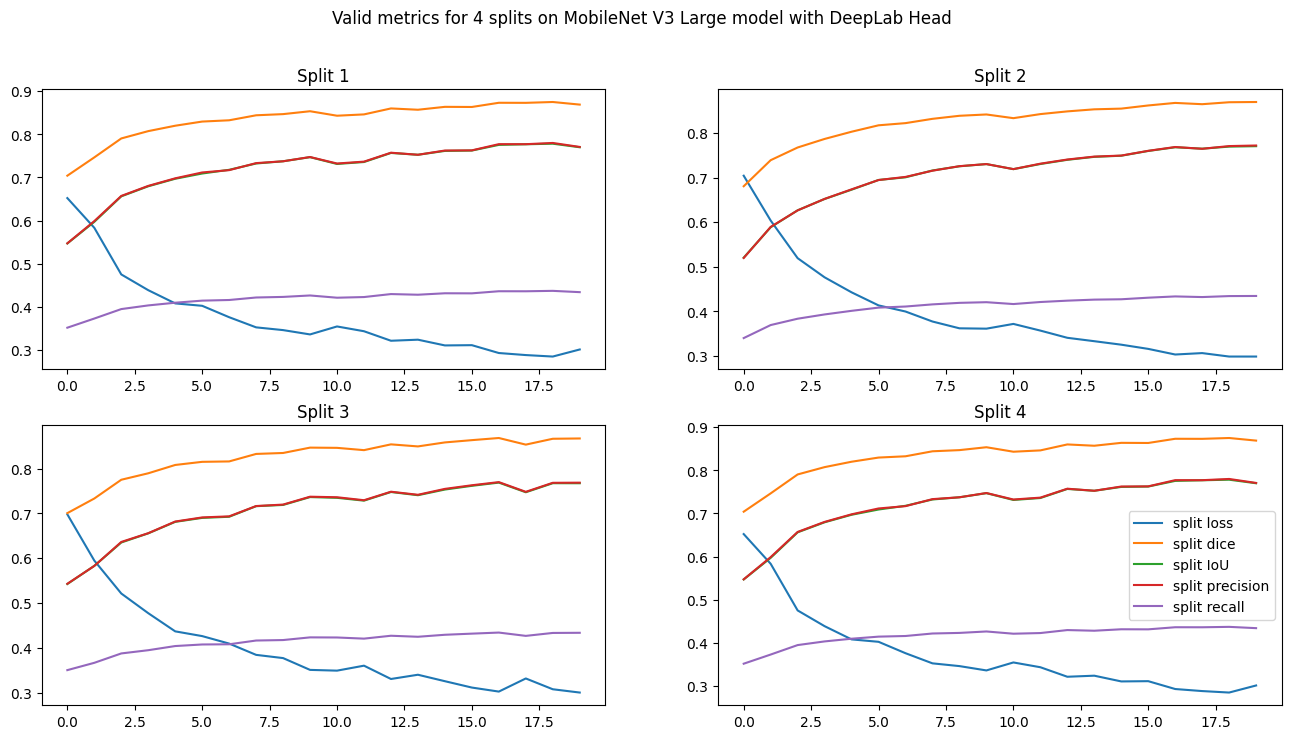

In [111]:
# splits_loss
# splits_dice
# splits_IoU
# splits_precision
# splits_recall
fig = plt.figure(num = 4, figsize=(16,8))
fig1 = fig.add_subplot(2,2,1)
fig2 = fig.add_subplot(2,2,2)
fig3 = fig.add_subplot(2,2,3)
fig4 = fig.add_subplot(2,2,4)

fig1.set_title("Split 1")
fig1.plot(splits_loss[0], label='split loss')
fig1.plot(splits_dice[0], label='split dice')
fig1.plot(splits_IoU[0], label='split IoU')
fig1.plot(splits_precision[0], label='split precision')
fig1.plot(splits_recall[0], label='split recall')

fig2.set_title("Split 2")
fig2.plot(splits_loss[1], label='split loss')
fig2.plot(splits_dice[1], label='split dice')
fig2.plot(splits_IoU[1], label='split IoU')
fig2.plot(splits_precision[1], label='split precision')
fig2.plot(splits_recall[1], label='split recall')

fig3.set_title("Split 3")
fig3.plot(splits_loss[2], label='split loss')
fig3.plot(splits_dice[2], label='split dice')
fig3.plot(splits_IoU[2], label='split IoU')
fig3.plot(splits_precision[2], label='split precision')
fig3.plot(splits_recall[2], label='split recall')

fig4.set_title("Split 4")
fig4.plot(splits_loss[0], label='split loss')
fig4.plot(splits_dice[0], label='split dice')
fig4.plot(splits_IoU[0], label='split IoU')
fig4.plot(splits_precision[0], label='split precision')
fig4.plot(splits_recall[0], label='split recall')
fig.suptitle("Valid metrics for 4 splits on MobileNet V3 Large model with DeepLab Head")
plt.legend()
plt.show()

In [26]:
EPOCHS = 20

criterion = BCEDiceLoss(eps=1.0, activation="sigmoid").to(device)

splits_loss_ = []
splits_dice_ = []
splits_IoU_ = []
splits_precision_ = []
splits_recall_ = []
LRs = []

for i, split in enumerate(cv_splits, start=1):
    print(f"----------------------------------------------Split={i}----------------------------------------------")
    
    model = fcn_resnet101(weights=FCN_ResNet101_Weights.DEFAULT)
    model.classifier.append(nn.Conv2d(21,1,1,1))
    model.aux_classifier.append(nn.Conv2d(21,1,1,1))
    model = model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=2e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
    
    x_train, x_test = train_test_split(split, test_size=0.2, random_state=101)
    ds_train = GeneratedImageDataset(x_train, 
                                     inputs_path,
                                     outputs_path,
                                     transform=transforms_,
                                     target_transform=target_transforms_
                                    )
    ds_test = GeneratedImageDataset(x_test,
                                    inputs_path,
                                    outputs_path,
                                    transform=transforms_,
                                    target_transform=target_transforms_
                                   )
    train_loader = DataLoader(ds_train, batch_size=16, shuffle=True)
    test_loader = DataLoader(ds_test, batch_size=16, shuffle=False)
    
    train_losses = []
    train_dices = []
    
    val_losses = []
    val_dices = []
    val_IoU = []
    val_precision = []
    val_recall = []
    
    lrs = []
    
    best_epoch_loss = np.inf
    
    for epoch in range(1, EPOCHS + 1):
        print(f"================================Started epoch №{epoch}================================")
        train_loss, train_dice = train(model, train_loader, optimizer, criterion)
        print("Train loss:", train_loss, "| train dice:", train_dice)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        epoch_loss, epoch_dice, epoch_IoU, epoch_precision, epoch_recall = evaluate(model, test_loader, criterion)
        print("Eval loss:", epoch_loss, "| eval dice:", epoch_dice,
              " | eval IoU:", epoch_IoU, " | eval precision:", epoch_precision, " | eval recall:", epoch_recall)
        val_losses.append(epoch_loss)
        val_dices.append(epoch_dice)
        val_IoU.append(epoch_IoU)
        val_precision.append(epoch_precision)
        val_recall.append(epoch_recall)
        if epoch_loss < best_epoch_loss:
            best_epoch_loss = epoch_loss
            torch.save(model.state_dict(), f"resnet101_fcn_split_{i}_bcediceloss-v2.pt")
            print("**********************************BEST VAL LOSS SCORE**********************************")
            print(f"BEST LOSS: {epoch_loss}, BEST DICE: {epoch_dice}, BEST IoU: {epoch_IoU}")
            print("***************************************************************************************")
        scheduler.step(epoch_loss)
        lrs.append([param_group["lr"] for param_group in optimizer.param_groups])
    splits_loss_.append(val_losses)
    splits_dice_.append(val_dices)
    splits_IoU_.append(val_IoU)
    splits_precision_.append(val_precision)
    splits_recall_.append(val_recall)
    LRs.append(lrs)

----------------------------------------------Split=1----------------------------------------------
================================Started epoch №1================================
------------------------------------------------------------------------------------------
| loss: 0.7317249992489815 | dice: 0.7212832275032998 | iter: [100/114]|
Train loss: 0.7081369158991596 | train dice: 0.7284917938604689
Eval loss: 0.5475787222385406 | eval dice: 0.7725253207930203  | eval IoU: 0.632258429609496  | eval precision: 0.6333360487017138  | eval recall: 0.3862623192113021
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.5475787222385406, BEST DICE: 0.7725253207930203, BEST IoU: 0.632258429609496
***************************************************************************************
================================Started epoch №2================================
------------------------------------------------------------------------------

Train loss: 0.24323559277936033 | train dice: 0.8955877998418975
Eval loss: 0.34371425673879424 | eval dice: 0.8529272285001032  | eval IoU: 0.7463357818537745  | eval precision: 0.7472904488958162  | eval recall: 0.4264633645271433
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.34371425673879424, BEST DICE: 0.8529272285001032, BEST IoU: 0.7463357818537745
***************************************************************************************
================================Started epoch №14================================
------------------------------------------------------------------------------------------
| loss: 0.23512162819504737 | dice: 0.8992356473207473 | iter: [100/114]|
Train loss: 0.2346972088541901 | train dice: 0.8993751087732482
Eval loss: 0.349910500234571 | eval dice: 0.8441962866947569  | eval IoU: 0.7345215411021792  | eval precision: 0.7348314873103438  | eval recall: 0.42209789465213643
=====================

------------------------------------------------------------------------------------------
| loss: 0.348783857524395 | dice: 0.8471111339330674 | iter: [100/114]|
Train loss: 0.35232717622267573 | train dice: 0.8459646257392147
Eval loss: 0.4110372796140868 | eval dice: 0.8145276739679533  | eval IoU: 0.6924466244105635  | eval precision: 0.6929788548370888  | eval recall: 0.4072634629134474
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.4110372796140868, BEST DICE: 0.8145276739679533, BEST IoU: 0.6924466244105635
***************************************************************************************
================================Started epoch №9================================
------------------------------------------------------------------------------------------
| loss: 0.34078183621168134 | dice: 0.8516840130090714 | iter: [100/114]|
Train loss: 0.33449997295413103 | train dice: 0.8538137078285217
Eval loss: 0.42763863503932

Train loss: 0.8154038977727556 | train dice: 0.7005437270068285
Eval loss: 0.5760034959891747 | eval dice: 0.7743487995246361  | eval IoU: 0.6361426947445705  | eval precision: 0.6367160431269941  | eval recall: 0.3871739928064675
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.5760034959891747, BEST DICE: 0.7743487995246361, BEST IoU: 0.6361426947445705
***************************************************************************************
================================Started epoch №2================================
------------------------------------------------------------------------------------------
| loss: 0.5210057273507118 | dice: 0.7879850941896439 | iter: [100/114]|
Train loss: 0.5165016235489595 | train dice: 0.7886344403551336
Eval loss: 0.4721525116213437 | eval dice: 0.8011907380202721  | eval IoU: 0.6707863951551503  | eval precision: 0.6717185953567768  | eval recall: 0.4005950514612527
**************************

Train loss: 0.2543537790576617 | train dice: 0.8912226045340822
Eval loss: 0.36933052488442125 | eval dice: 0.8409366792645948  | eval IoU: 0.7290048969203028  | eval precision: 0.7295088192512249  | eval recall: 0.4204680673007307
================================Started epoch №16================================
------------------------------------------------------------------------------------------
| loss: 0.2332674652338028 | dice: 0.90184883415699 | iter: [100/114]|
Train loss: 0.23071330668110596 | train dice: 0.9023932046011874
Eval loss: 0.3899693350339758 | eval dice: 0.8326266983459736  | eval IoU: 0.7185532286249358  | eval precision: 0.719074508239483  | eval recall: 0.4163130460114315
================================Started epoch №17================================
------------------------------------------------------------------------------------------
| loss: 0.23624954894185066 | dice: 0.9000744867324829 | iter: [100/114]|
Train loss: 0.2418295443058014 | train dice: 0

Eval loss: 0.4094132107907328 | eval dice: 0.8237021544883991  | eval IoU: 0.7054249654556143  | eval precision: 0.70554050392118  | eval recall: 0.4118507853869734
**********************************BEST VAL LOSS SCORE**********************************
BEST LOSS: 0.4094132107907328, BEST DICE: 0.8237021544883991, BEST IoU: 0.7054249654556143
***************************************************************************************
================================Started epoch №9================================
------------------------------------------------------------------------------------------
| loss: 0.3382618184387684 | dice: 0.8556242352724075 | iter: [100/114]|
Train loss: 0.33618155644651043 | train dice: 0.8563158438916791
Eval loss: 0.43465376259951755 | eval dice: 0.815262219001507  | eval IoU: 0.6920131927934187  | eval precision: 0.6937095748967138  | eval recall: 0.4076308320308554
================================Started epoch №10================================
---------

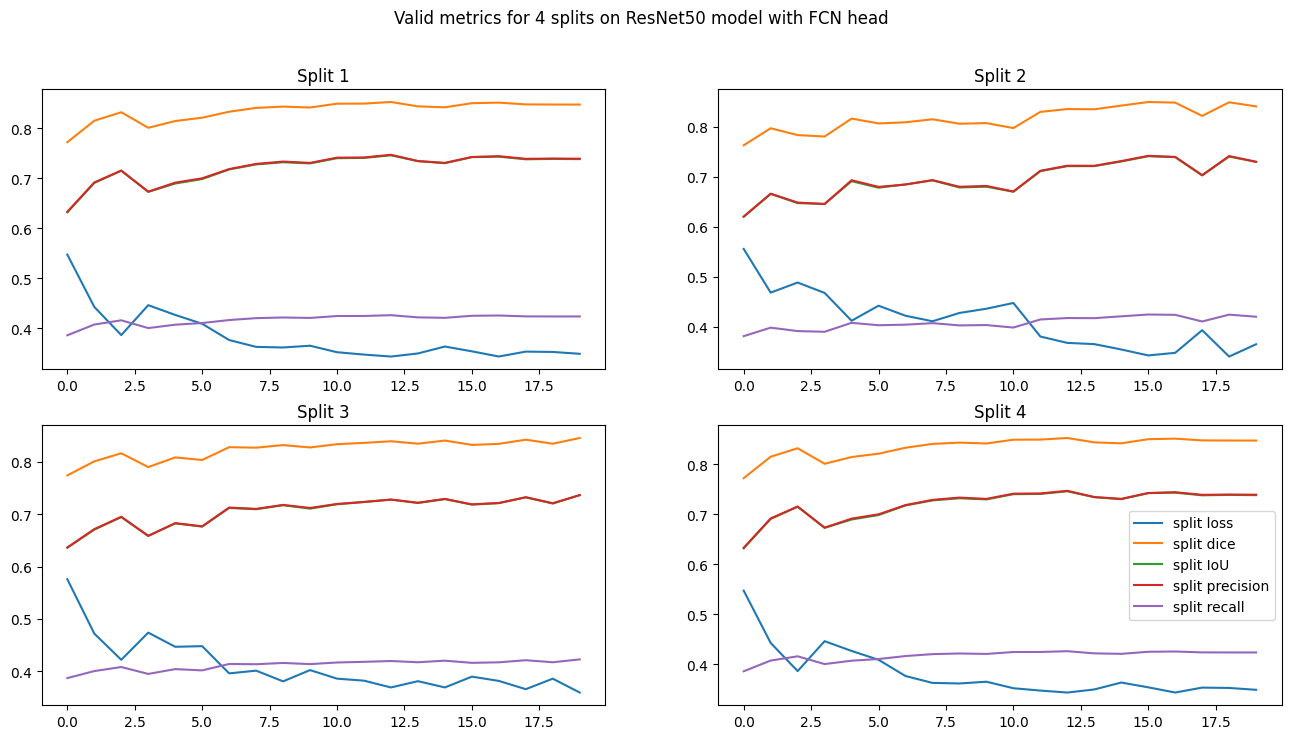

In [28]:
# splits_loss
# splits_dice
# splits_IoU
# splits_precision
# splits_recall
fig = plt.figure(num = 4, figsize=(16,8))
fig1 = fig.add_subplot(2,2,1)
fig2 = fig.add_subplot(2,2,2)
fig3 = fig.add_subplot(2,2,3)
fig4 = fig.add_subplot(2,2,4)

fig1.set_title("Split 1")
fig1.plot(splits_loss_[0], label='split loss')
fig1.plot(splits_dice_[0], label='split dice')
fig1.plot(splits_IoU_[0], label='split IoU')
fig1.plot(splits_precision_[0], label='split precision')
fig1.plot(splits_recall_[0], label='split recall')

fig2.set_title("Split 2")
fig2.plot(splits_loss_[1], label='split loss')
fig2.plot(splits_dice_[1], label='split dice')
fig2.plot(splits_IoU_[1], label='split IoU')
fig2.plot(splits_precision_[1], label='split precision')
fig2.plot(splits_recall_[1], label='split recall')

fig3.set_title("Split 3")
fig3.plot(splits_loss_[2], label='split loss')
fig3.plot(splits_dice_[2], label='split dice')
fig3.plot(splits_IoU_[2], label='split IoU')
fig3.plot(splits_precision_[2], label='split precision')
fig3.plot(splits_recall_[2], label='split recall')

fig4.set_title("Split 4")
fig4.plot(splits_loss_[0], label='split loss')
fig4.plot(splits_dice_[0], label='split dice')
fig4.plot(splits_IoU_[0], label='split IoU')
fig4.plot(splits_precision_[0], label='split precision')
fig4.plot(splits_recall_[0], label='split recall')
fig.suptitle("Valid metrics for 4 splits on ResNet50 model with FCN head")
plt.legend()
plt.show()

In [29]:
ds_val = GeneratedImageDataset(df_val,
                                    inputs_path,
                                    outputs_path,
                                    transform=transforms_,
                                    target_transform=target_transforms_
                                   )
val_loader = DataLoader(ds_val, batch_size=16, shuffle=True)

for i in range(1, 5):
    model = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
    model.classifier.append(nn.Conv2d(21,1,1,1))
    model.aux_classifier.append(nn.Conv2d(21,1,1,1))
    model.load_state_dict(torch.load(f"resnet50_fcn_split_{i}_bcediceloss-v2.pt"))
    model = model.to(device)
    loss_, dice_, iou_, precision_, recall_ = evaluate(model, val_loader, criterion)
    print(f"=====================MODEL {i}=====================")
    print("Loss:", loss_, "dice:", dice_, "iou:", iou_, "precision:", precision_, "recall:", recall_)

------------------------------------------------------------------------------------------
| loss: 0.3898619896173477 | dice: 0.836412768959999 | iter: [100/244]|
| IoU: 0.7226394462585449 | recall: 0.41820613741874696 | iter: [100/244]|
| precision: 0.7230987936258316 | iter: [100/244]|
------------------------------------------------------------------------------------------
| loss: 0.3907685298472643 | dice: 0.835477450788021 | iter: [200/244]|
| IoU: 0.7210699492692947 | recall: 0.41773847341537473 | iter: [200/244]|
| precision: 0.7215775740146637 | iter: [200/244]|
=====================MODEL 1=====================
Loss: 0.38471269509831413 dice: 0.837028626047197 iou: 0.7233246928844296 precision: 0.7238790612728869 recall: 0.41851405787174817
------------------------------------------------------------------------------------------
| loss: 0.37229183688759804 | dice: 0.8413115346431732 | iter: [100/244]|
| IoU: 0.7286979213356972 | recall: 0.42065551578998567 | iter: [100/244]|


In [14]:
from torchvision.utils import draw_segmentation_masks, make_grid
import os

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


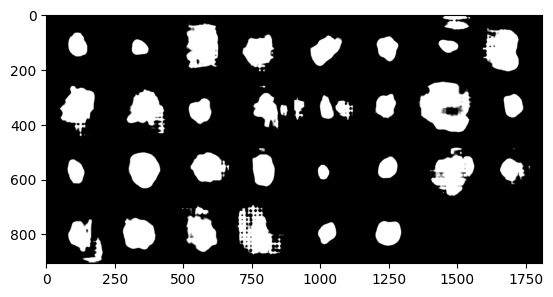

In [145]:
images = os.listdir("IMG-3")
random_sampled_images = np.random.choice(images, 30)

model = fcn_resnet101(weights=FCN_ResNet101_Weights.DEFAULT)
model.classifier.append(nn.Conv2d(21,1,1,1))
model.aux_classifier.append(nn.Conv2d(21,1,1,1))
model.load_state_dict(torch.load("resnet50_fcn_split_2_bcediceloss-v2.pt"))
model = model.to(device)

transform = v2.Compose([
    v2.Resize((232, 232)),
    v2.CentralCrop((224,224)),
    v2.RandomErase(p=0.1)
])

masks = []

for img in random_sampled_images:
    masks.append(model(transform(read_image(f"IMG-3/{img}")).float().unsqueeze(0).to(device))["out"].squeeze(0))

plt.imshow(make_grid(masks).cpu().permute(1, 2, 0).numpy())

In [156]:
overlays = []
for im, ma in zip(random_sampled_images, masks):
    overlays.append(draw_segmentation_masks(transform(read_image(f"IMG-3/{im}")), torch.nn.functional.sigmoid(ma).round().cpu().bool(), alpha=0.3, colors=(240, 10, 157)))

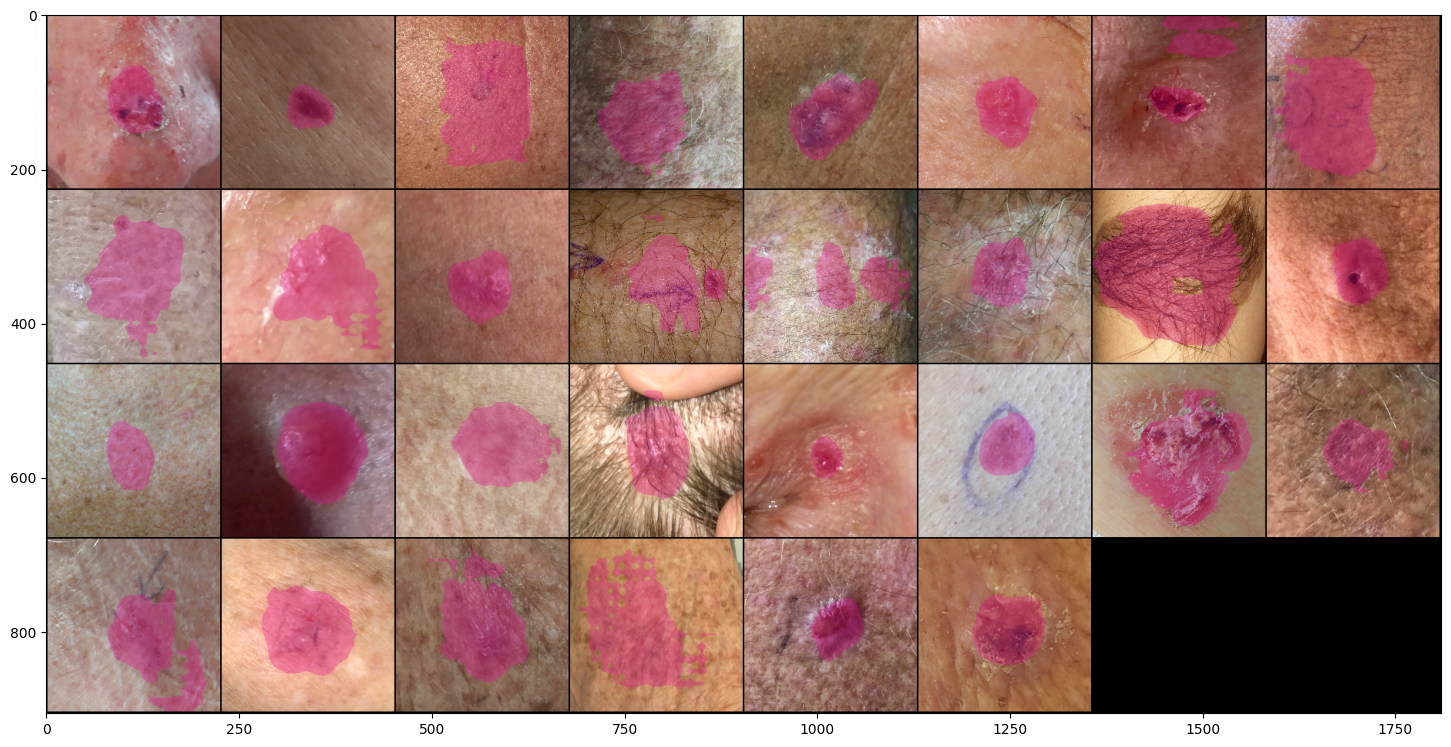

In [157]:
plt.figure(figsize=(18,10))
plt.imshow(make_grid(overlays[:32]).cpu().permute(1, 2, 0).numpy())

In [153]:
EPOCHS = 30

criterion = BCEDiceLoss(eps=1.0, activation="sigmoid").to(device)

LRs = []


model = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
model.classifier.append(nn.Conv2d(21,1,1,1))
model.aux_classifier.append(nn.Conv2d(21,1,1,1))
model = model.to(device)
        
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
    
ds_train = GeneratedImageDataset(df_train, 
                                    inputs_path,
                                    outputs_path,
                                    transform=transforms_,
                                    target_transform=target_transforms_
                                )
ds_test = GeneratedImageDataset(df_val,
                                    inputs_path,
                                    outputs_path,
                                    transform=transforms_,
                                    target_transform=target_transforms_
                                )
train_loader = DataLoader(ds_train, batch_size=16, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=16, shuffle=False)
    
train_losses = []
train_dices = []
    
val_losses = []
val_dices = []
val_IoU = []
val_precision = []
val_recall = []
    
best_epoch_loss = np.inf
    
for epoch in range(1, EPOCHS + 1):
    print(f"================================Started epoch №{epoch}================================")
    train_loss, train_dice = train(model, train_loader, optimizer, criterion)
    print("Train loss:", train_loss, "| train dice:", train_dice)
    train_losses.append(train_loss)
    train_dices.append(train_dice)
    epoch_loss, epoch_dice, epoch_IoU, epoch_precision, epoch_recall = evaluate(model, test_loader, criterion)
    print("Eval loss:", epoch_loss, "| eval dice:", epoch_dice,
            " | eval IoU:", epoch_IoU, " | eval precision:", epoch_precision, " | eval recall:", epoch_recall)
    val_losses.append(epoch_loss)
    val_dices.append(epoch_dice)
    val_IoU.append(epoch_IoU)
    val_precision.append(epoch_precision)
    val_recall.append(epoch_recall)
    if epoch_loss < best_epoch_loss:
        best_epoch_loss = epoch_loss
        torch.save(model.state_dict(), f"resnet50_fcn_split_max_bcediceloss-v2.pt")
        print("**********************************BEST VAL LOSS SCORE**********************************")
        print(f"BEST LOSS: {epoch_loss}, BEST DICE: {epoch_dice}, BEST IoU: {epoch_IoU}")
        print("***************************************************************************************")
    scheduler.step(epoch_loss)
    LRs.append([pg["lr"] for pg in optimizer.param_groups][0])

================================Started epoch №1================================
------------------------------------------------------------------------------------------
| loss: 0.9367541170120239 | dice: 0.6675367519259453 | iter: [100/568]|
------------------------------------------------------------------------------------------
| loss: 0.7786173318326474 | dice: 0.7076113988459111 | iter: [200/568]|
------------------------------------------------------------------------------------------
| loss: 0.6992341284950574 | dice: 0.7291013291478157 | iter: [300/568]|
------------------------------------------------------------------------------------------
| loss: 0.6532541058212519 | dice: 0.7408504357933998 | iter: [400/568]|
------------------------------------------------------------------------------------------
| loss: 0.624328231036663 | dice: 0.7486876378059387 | iter: [500/568]|
Train loss: 0.6079147601316512 | train dice: 0.7529287478873428
------------------------------------

------------------------------------------------------------------------------------------
| loss: 0.40608356778820354 | dice: 0.8218675331274669 | iter: [300/568]|
------------------------------------------------------------------------------------------
| loss: 0.40409830052405593 | dice: 0.8222532749176026 | iter: [400/568]|
------------------------------------------------------------------------------------------
| loss: 0.39698608857393264 | dice: 0.8258630294799805 | iter: [500/568]|
Train loss: 0.3951175374988939 | train dice: 0.8264939902533948
------------------------------------------------------------------------------------------
| loss: 0.40577042907476424 | dice: 0.8257624727487564 | iter: [100/244]|
| IoU: 0.7070128014683723 | recall: 0.4128809681534767 | iter: [100/244]|
| precision: 0.7074998399615288 | iter: [100/244]|
------------------------------------------------------------------------------------------
| loss: 0.4175133080035448 | dice: 0.8199747365713119 | iter

------------------------------------------------------------------------------------------
| loss: 0.4091554883867502 | dice: 0.8226446598768234 | iter: [200/244]|
| IoU: 0.7030625231564045 | recall: 0.41132204681634904 | iter: [200/244]|
| precision: 0.7034274411201477 | iter: [200/244]|
Eval loss: 0.4077254949045963 | eval dice: 0.8225290306278916  | eval IoU: 0.7028691320389998  | eval precision: 0.7032106765469567  | eval recall: 0.4112642285276632
================================Started epoch №10================================
------------------------------------------------------------------------------------------
| loss: 0.36683993712067603 | dice: 0.8419184905290603 | iter: [100/568]|
------------------------------------------------------------------------------------------
| loss: 0.3510467330366373 | dice: 0.8459086534380913 | iter: [200/568]|
------------------------------------------------------------------------------------------
| loss: 0.3503190499544144 | dice: 0.8461

------------------------------------------------------------------------------------------
| loss: 0.27720313042402267 | dice: 0.8790758258104324 | iter: [100/568]|
------------------------------------------------------------------------------------------
| loss: 0.27295140527188777 | dice: 0.881177619099617 | iter: [200/568]|
------------------------------------------------------------------------------------------
| loss: 0.27748319442073505 | dice: 0.879249113202095 | iter: [300/568]|
------------------------------------------------------------------------------------------
| loss: 0.27348109748214483 | dice: 0.8804444743692875 | iter: [400/568]|
------------------------------------------------------------------------------------------
| loss: 0.27429190880060195 | dice: 0.8800701658725738 | iter: [500/568]|
Train loss: 0.2756213359797085 | train dice: 0.879093108357678
------------------------------------------------------------------------------------------
| loss: 0.3329059602320

------------------------------------------------------------------------------------------
| loss: 0.33537173360586164 | dice: 0.856249041557312 | iter: [200/244]|
| IoU: 0.7515559765696526 | recall: 0.42812429562211035 | iter: [200/244]|
| precision: 0.7521700558066368 | iter: [200/244]|
Eval loss: 0.33744864379529094 | eval dice: 0.8551856347771941  | eval IoU: 0.7501446309148289  | eval precision: 0.7507502101972455  | eval recall: 0.4275925884969899
================================Started epoch №19================================
------------------------------------------------------------------------------------------
| loss: 0.2597466552257538 | dice: 0.8852759683132172 | iter: [100/568]|
------------------------------------------------------------------------------------------
| loss: 0.2614223802834749 | dice: 0.8852215638756752 | iter: [200/568]|
------------------------------------------------------------------------------------------
| loss: 0.2579896693925063 | dice: 0.8873

------------------------------------------------------------------------------------------
| loss: 0.2357157222678264 | dice: 0.8968423368533452 | iter: [300/568]|
------------------------------------------------------------------------------------------
| loss: 0.2376760753430426 | dice: 0.895848338752985 | iter: [400/568]|
------------------------------------------------------------------------------------------
| loss: 0.2399891581684351 | dice: 0.8942770847082138 | iter: [500/568]|
Train loss: 0.24039240434608408 | train dice: 0.8943389038174925
------------------------------------------------------------------------------------------
| loss: 0.3160515736043453 | dice: 0.8635438430309296 | iter: [100/244]|
| IoU: 0.7632181161642074 | recall: 0.43177170723676683 | iter: [100/244]|
| precision: 0.7641969695687294 | iter: [100/244]|
------------------------------------------------------------------------------------------
| loss: 0.3202010600268841 | dice: 0.86254251152277 | iter: [20

Eval loss: 0.3255753329054254 | eval dice: 0.8599582671142015  | eval IoU: 0.7572030195447265  | eval precision: 0.7577839165193135  | eval recall: 0.4299789073525882
================================Started epoch №28================================
------------------------------------------------------------------------------------------
| loss: 0.23399917930364608 | dice: 0.8962889593839646 | iter: [100/568]|
------------------------------------------------------------------------------------------
| loss: 0.23765776291489601 | dice: 0.8967778992652893 | iter: [200/568]|
------------------------------------------------------------------------------------------
| loss: 0.2372229606906573 | dice: 0.8966739318768183 | iter: [300/568]|
------------------------------------------------------------------------------------------
| loss: 0.23849235344678163 | dice: 0.8952627494931221 | iter: [400/568]|
------------------------------------------------------------------------------------------
|

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


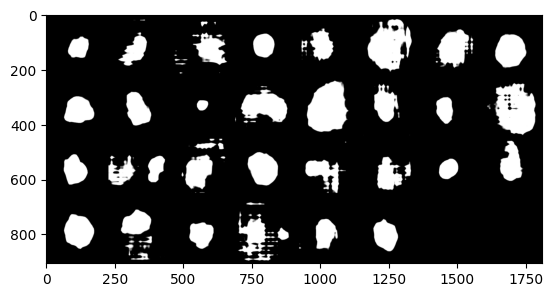

In [15]:
images = os.listdir("IMG-3")
random_sampled_images = np.random.choice(images, 30)

model = fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)
model.classifier.append(nn.Conv2d(21,1,1,1))
model.aux_classifier.append(nn.Conv2d(21,1,1,1))
model.load_state_dict(torch.load("resnet50_fcn_split_max_bcediceloss-v2.pt"))
model = model.to(device)

transform = v2.Compose([
    v2.Resize((224, 224))
])

masks = []

for img in random_sampled_images:
    masks.append(model(transform(read_image(f"IMG-3/{img}")).float().unsqueeze(0).to(device))["out"].squeeze(0))

plt.imshow(make_grid(masks).cpu().permute(1, 2, 0).numpy())

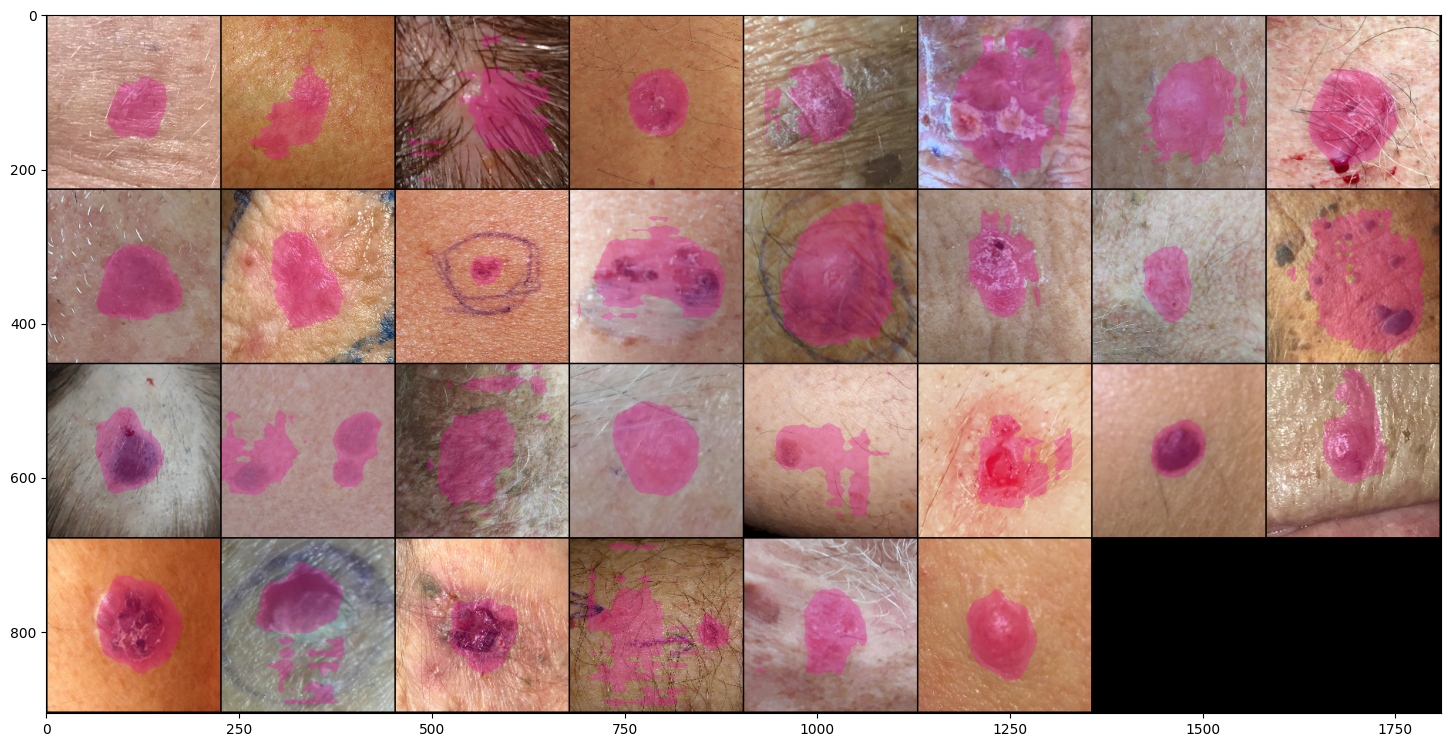

In [16]:
overlays = []
for im, ma in zip(random_sampled_images, masks):
    overlays.append(draw_segmentation_masks(transform(read_image(f"IMG-3/{im}")), torch.nn.functional.sigmoid(ma).round().cpu().bool(), alpha=0.3, colors=(240, 10, 157)))
plt.figure(figsize=(18,10))
plt.imshow(make_grid(overlays[:32]).cpu().permute(1, 2, 0).numpy())

In [17]:
from albumentations import CLAHE

ModuleNotFoundError: No module named 'albumentations'

In [2]:
fcn_resnet50(weights=FCN_ResNet50_Weights.DEFAULT)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti